# WeatherPy
----

### Analysis
* As expected, the weather becomes significantly warmer as one approaches the equator (0 Deg. Latitude). More interestingly, however, is the fact that the southern hemisphere tends to be warmer this time of year than the northern hemisphere. This may be due to the tilt of the earth.
* There is no strong relationship between latitude and cloudiness. However, it is interesting to see that a strong band of cities sits at 0, 80, and 100% cloudiness.
* There is no strong relationship between latitude and wind speed. However, in northern hemispheres there is a flurry of cities with over 20 mph of wind.

---

#### Note
* Instructions have been included for each segment. You do not have to follow them exactly, but they are included to help you think through the steps.

In [1]:
 # Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
import json
import openweathermapy.core as owm
from datetime import datetime
from pprint import pprint


# Import API key
import api_keys

# Incorporated citipy to determine city based on latitude and longitude
from citipy import citipy

# Output File (CSV)
output_data_file = "output_data/cities.csv"

# Range of latitudes and longitudes
lat_range = (-90, 90)
lng_range = (-180, 180)

## Generate Cities List

In [2]:
# List for holding lat_lngs and cities
lat_lngs = []
cities = []

# Create a set of random lat and lng combinations
lats = np.random.uniform(low=-90.000, high=90.000, size=1500)
lngs = np.random.uniform(low=-180.000, high=180.000, size=1500)
lat_lngs = zip(lats, lngs)

# Identify nearest city for each lat, lng combination
for lat_lng in lat_lngs:
    city = citipy.nearest_city(lat_lng[0], lat_lng[1]).city_name
    
    # If the city is unique, then add it to a our cities list
    if city not in cities:
        cities.append(city)

# Print the city count to confirm sufficient count
len(cities)

611

In [3]:
# Create empty data frame and add columns for city, country, latitude and longitude
cities_list = pd.DataFrame()
cities_list["City"] = ""
cities_list["Country"] = ""
# Randomly generate numbers for latitude and longitude and loop through 500 times
cities_list["Latitude"] = [np.random.uniform(-90, 90) for x in range(1500)]
cities_list["Longitude"] = [np.random.uniform(-180, 180) for x in range(1500)]
# Use latitude and longitude to find city and country by using interrows and citipy
for index, row in cities_list.iterrows():
    lat = row["Latitude"]
    lng = row["Longitude"]
    cities_list.set_value(index, "City", citipy.nearest_city(lat, lng).city_name)
    cities_list.set_value(index, "Country", citipy.nearest_city(lat, lng).country_code)
# Delete any possible duplicate cities and reset index
cities_list = cities_list.drop_duplicates(["City", "Country"])
cities_list = cities_list.reset_index()
# Update data frame to just city and country column
cities_list = cities_list[["City", "Country"]]
cities_list = cities_list.iloc[:500]
cities_list

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  if sys.path[0] == '':
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  del sys.path[0]


,City,Country
0,benguela,ao
1,arman,ru
2,port lincoln,au
3,lavrentiya,ru
4,vung tau,vn
5,kapaa,us
6,bambous virieux,mu
7,quixere,br
8,tautira,pf
9,avarua,ck


### Perform API Calls
* Perform a weather check on each city using a series of successive API calls.
* Include a print log of each city as it'sbeing processed (with the city number and city name).


In [4]:
# Perform API calls and display results in Data Frame
cities_list["Cloudiness"] = ""
cities_list["Date"] = ""
cities_list["Humidity"] = ""
cities_list["Latitude"] = ""
cities_list["Longitude"] = ""
cities_list["Max Temperature"] = ""
cities_list["Wind Speed"] = ""

# Create row counter and set it to one
row_counter = 1
# Create a dictionary with parameters
settings = {"appid": api_keys, "units": "imperial"}
# Create a base url
base_url = "http://api.openweathermap.org/data/2.5/weather?"
# Create query url
query_url = f"{base_url}appid={settings['appid']}&units={settings['units']}&q="

print("Beginning Data Retrieval")
print("---------------------------")
# Iterrows in to loop city row in query url
for index, row in cities_list.iterrows():
    try:
        cities_response = requests.get(query_url + row["City"] + "," + row["Country"])
        print(f"Processing Record {row_counter} | {row['City']}, {row['Country']}")
        print(cities_response.url)
        # Update row counter
        row_counter += 1
        # Turn cities response into json with owm module
        cities_response = owm.get_current(row["City"], **settings)
    
        # Create summary variables to retrieve certain data from cities response
        lat_summary = ["coord.lat"]
        lon_summary = ["coord.lon"]
        temp_summary = ["main.temp_max"]
        humidity_summary = ["main.humidity"]
        cloud_summary = ["clouds.all"]
        wind_summary = ["wind.speed"]
        date_summary = ["dt"]
    
        # Add retrieved data into cities_list data frame
        cities_list.set_value(index, "Cloudiness", cities_response(*cloud_summary))
        cities_list.set_value(index, "Date", cities_response(*date_summary))
        cities_list.set_value(index, "Humidity", cities_response(*humidity_summary))
        cities_list.set_value(index, "Latitude", cities_response(*lat_summary))
        cities_list.set_value(index, "Longitude", cities_response(*lon_summary))
        cities_list.set_value(index, "Max Temperature", cities_response(*temp_summary))
        cities_list.set_value(index, "Wind Speed", cities_response(*wind_summary))
    except:
        print(f"City not found. Skipping... {row['City']}, {row['Country']}")
        continue
    
print("---------------------------")
print("Data Retrieval Complete")
print("---------------------------")

Beginning Data Retrieval
---------------------------
Processing Record 1 | benguela, ao
http://api.openweathermap.org/data/2.5/weather?appid=%3Cmodule%20'api_keys'%20from%20'/Users/katherinemorriss/Desktop/UKED201808DATA5/06-Python-APIs/Homework/Instructions/starter_code/api_keys.py'%3E&units=imperial&q=benguela,ao
City not found. Skipping... benguela, ao
Processing Record 2 | arman, ru
http://api.openweathermap.org/data/2.5/weather?appid=%3Cmodule%20'api_keys'%20from%20'/Users/katherinemorriss/Desktop/UKED201808DATA5/06-Python-APIs/Homework/Instructions/starter_code/api_keys.py'%3E&units=imperial&q=arman,ru
City not found. Skipping... arman, ru
Processing Record 3 | port lincoln, au
http://api.openweathermap.org/data/2.5/weather?appid=%3Cmodule%20'api_keys'%20from%20'/Users/katherinemorriss/Desktop/UKED201808DATA5/06-Python-APIs/Homework/Instructions/starter_code/api_keys.py'%3E&units=imperial&q=port%20lincoln,au
City not found. Skipping... port lincoln, au
Processing Record 4 | lavre

City not found. Skipping... barrow, us
Processing Record 29 | deputatskiy, ru
http://api.openweathermap.org/data/2.5/weather?appid=%3Cmodule%20'api_keys'%20from%20'/Users/katherinemorriss/Desktop/UKED201808DATA5/06-Python-APIs/Homework/Instructions/starter_code/api_keys.py'%3E&units=imperial&q=deputatskiy,ru
City not found. Skipping... deputatskiy, ru
Processing Record 30 | busselton, au
http://api.openweathermap.org/data/2.5/weather?appid=%3Cmodule%20'api_keys'%20from%20'/Users/katherinemorriss/Desktop/UKED201808DATA5/06-Python-APIs/Homework/Instructions/starter_code/api_keys.py'%3E&units=imperial&q=busselton,au
City not found. Skipping... busselton, au
Processing Record 31 | ushuaia, ar
http://api.openweathermap.org/data/2.5/weather?appid=%3Cmodule%20'api_keys'%20from%20'/Users/katherinemorriss/Desktop/UKED201808DATA5/06-Python-APIs/Homework/Instructions/starter_code/api_keys.py'%3E&units=imperial&q=ushuaia,ar
City not found. Skipping... ushuaia, ar
Processing Record 32 | moscow, us


City not found. Skipping... auki, sb
Processing Record 56 | nampula, mz
http://api.openweathermap.org/data/2.5/weather?appid=%3Cmodule%20'api_keys'%20from%20'/Users/katherinemorriss/Desktop/UKED201808DATA5/06-Python-APIs/Homework/Instructions/starter_code/api_keys.py'%3E&units=imperial&q=nampula,mz
City not found. Skipping... nampula, mz
Processing Record 57 | nacala, mz
http://api.openweathermap.org/data/2.5/weather?appid=%3Cmodule%20'api_keys'%20from%20'/Users/katherinemorriss/Desktop/UKED201808DATA5/06-Python-APIs/Homework/Instructions/starter_code/api_keys.py'%3E&units=imperial&q=nacala,mz
City not found. Skipping... nacala, mz
Processing Record 58 | tsihombe, mg
http://api.openweathermap.org/data/2.5/weather?appid=%3Cmodule%20'api_keys'%20from%20'/Users/katherinemorriss/Desktop/UKED201808DATA5/06-Python-APIs/Homework/Instructions/starter_code/api_keys.py'%3E&units=imperial&q=tsihombe,mg
City not found. Skipping... tsihombe, mg
Processing Record 59 | ostrovnoy, ru
http://api.openwe

Processing Record 83 | half moon bay, us
http://api.openweathermap.org/data/2.5/weather?appid=%3Cmodule%20'api_keys'%20from%20'/Users/katherinemorriss/Desktop/UKED201808DATA5/06-Python-APIs/Homework/Instructions/starter_code/api_keys.py'%3E&units=imperial&q=half%20moon%20bay,us
City not found. Skipping... half moon bay, us
Processing Record 84 | victoria, sc
http://api.openweathermap.org/data/2.5/weather?appid=%3Cmodule%20'api_keys'%20from%20'/Users/katherinemorriss/Desktop/UKED201808DATA5/06-Python-APIs/Homework/Instructions/starter_code/api_keys.py'%3E&units=imperial&q=victoria,sc
City not found. Skipping... victoria, sc
Processing Record 85 | saint george, bm
http://api.openweathermap.org/data/2.5/weather?appid=%3Cmodule%20'api_keys'%20from%20'/Users/katherinemorriss/Desktop/UKED201808DATA5/06-Python-APIs/Homework/Instructions/starter_code/api_keys.py'%3E&units=imperial&q=saint%20george,bm
City not found. Skipping... saint george, bm
Processing Record 86 | grand river south east, mu

City not found. Skipping... bluff, nz
Processing Record 110 | kaeo, nz
http://api.openweathermap.org/data/2.5/weather?appid=%3Cmodule%20'api_keys'%20from%20'/Users/katherinemorriss/Desktop/UKED201808DATA5/06-Python-APIs/Homework/Instructions/starter_code/api_keys.py'%3E&units=imperial&q=kaeo,nz
City not found. Skipping... kaeo, nz
Processing Record 111 | provideniya, ru
http://api.openweathermap.org/data/2.5/weather?appid=%3Cmodule%20'api_keys'%20from%20'/Users/katherinemorriss/Desktop/UKED201808DATA5/06-Python-APIs/Homework/Instructions/starter_code/api_keys.py'%3E&units=imperial&q=provideniya,ru
City not found. Skipping... provideniya, ru
Processing Record 112 | tasiilaq, gl
http://api.openweathermap.org/data/2.5/weather?appid=%3Cmodule%20'api_keys'%20from%20'/Users/katherinemorriss/Desktop/UKED201808DATA5/06-Python-APIs/Homework/Instructions/starter_code/api_keys.py'%3E&units=imperial&q=tasiilaq,gl
City not found. Skipping... tasiilaq, gl
Processing Record 113 | port macquarie, au
h

City not found. Skipping... goderich, sl
Processing Record 138 | sechura, pe
http://api.openweathermap.org/data/2.5/weather?appid=%3Cmodule%20'api_keys'%20from%20'/Users/katherinemorriss/Desktop/UKED201808DATA5/06-Python-APIs/Homework/Instructions/starter_code/api_keys.py'%3E&units=imperial&q=sechura,pe
City not found. Skipping... sechura, pe
Processing Record 139 | ushibuka, jp
http://api.openweathermap.org/data/2.5/weather?appid=%3Cmodule%20'api_keys'%20from%20'/Users/katherinemorriss/Desktop/UKED201808DATA5/06-Python-APIs/Homework/Instructions/starter_code/api_keys.py'%3E&units=imperial&q=ushibuka,jp
City not found. Skipping... ushibuka, jp
Processing Record 140 | ust-maya, ru
http://api.openweathermap.org/data/2.5/weather?appid=%3Cmodule%20'api_keys'%20from%20'/Users/katherinemorriss/Desktop/UKED201808DATA5/06-Python-APIs/Homework/Instructions/starter_code/api_keys.py'%3E&units=imperial&q=ust-maya,ru
City not found. Skipping... ust-maya, ru
Processing Record 141 | vila franca do ca

City not found. Skipping... vysokogornyy, ru
Processing Record 166 | porto santo, pt
http://api.openweathermap.org/data/2.5/weather?appid=%3Cmodule%20'api_keys'%20from%20'/Users/katherinemorriss/Desktop/UKED201808DATA5/06-Python-APIs/Homework/Instructions/starter_code/api_keys.py'%3E&units=imperial&q=porto%20santo,pt
City not found. Skipping... porto santo, pt
Processing Record 167 | berlevag, no
http://api.openweathermap.org/data/2.5/weather?appid=%3Cmodule%20'api_keys'%20from%20'/Users/katherinemorriss/Desktop/UKED201808DATA5/06-Python-APIs/Homework/Instructions/starter_code/api_keys.py'%3E&units=imperial&q=berlevag,no
City not found. Skipping... berlevag, no
Processing Record 168 | makhalino, ru
http://api.openweathermap.org/data/2.5/weather?appid=%3Cmodule%20'api_keys'%20from%20'/Users/katherinemorriss/Desktop/UKED201808DATA5/06-Python-APIs/Homework/Instructions/starter_code/api_keys.py'%3E&units=imperial&q=makhalino,ru
City not found. Skipping... makhalino, ru
Processing Record 16

Processing Record 193 | santa cruz, cr
http://api.openweathermap.org/data/2.5/weather?appid=%3Cmodule%20'api_keys'%20from%20'/Users/katherinemorriss/Desktop/UKED201808DATA5/06-Python-APIs/Homework/Instructions/starter_code/api_keys.py'%3E&units=imperial&q=santa%20cruz,cr
City not found. Skipping... santa cruz, cr
Processing Record 194 | khatanga, ru
http://api.openweathermap.org/data/2.5/weather?appid=%3Cmodule%20'api_keys'%20from%20'/Users/katherinemorriss/Desktop/UKED201808DATA5/06-Python-APIs/Homework/Instructions/starter_code/api_keys.py'%3E&units=imperial&q=khatanga,ru
City not found. Skipping... khatanga, ru
Processing Record 195 | ternate, id
http://api.openweathermap.org/data/2.5/weather?appid=%3Cmodule%20'api_keys'%20from%20'/Users/katherinemorriss/Desktop/UKED201808DATA5/06-Python-APIs/Homework/Instructions/starter_code/api_keys.py'%3E&units=imperial&q=ternate,id
City not found. Skipping... ternate, id
Processing Record 196 | kearney, us
http://api.openweathermap.org/data/2.5

City not found. Skipping... borama, so
Processing Record 220 | vanavara, ru
http://api.openweathermap.org/data/2.5/weather?appid=%3Cmodule%20'api_keys'%20from%20'/Users/katherinemorriss/Desktop/UKED201808DATA5/06-Python-APIs/Homework/Instructions/starter_code/api_keys.py'%3E&units=imperial&q=vanavara,ru
City not found. Skipping... vanavara, ru
Processing Record 221 | iqaluit, ca
http://api.openweathermap.org/data/2.5/weather?appid=%3Cmodule%20'api_keys'%20from%20'/Users/katherinemorriss/Desktop/UKED201808DATA5/06-Python-APIs/Homework/Instructions/starter_code/api_keys.py'%3E&units=imperial&q=iqaluit,ca
City not found. Skipping... iqaluit, ca
Processing Record 222 | vegachi, co
http://api.openweathermap.org/data/2.5/weather?appid=%3Cmodule%20'api_keys'%20from%20'/Users/katherinemorriss/Desktop/UKED201808DATA5/06-Python-APIs/Homework/Instructions/starter_code/api_keys.py'%3E&units=imperial&q=vegachi,co
City not found. Skipping... vegachi, co
Processing Record 223 | vidim, ru
http://api.o

Processing Record 247 | sao borja, br
http://api.openweathermap.org/data/2.5/weather?appid=%3Cmodule%20'api_keys'%20from%20'/Users/katherinemorriss/Desktop/UKED201808DATA5/06-Python-APIs/Homework/Instructions/starter_code/api_keys.py'%3E&units=imperial&q=sao%20borja,br
City not found. Skipping... sao borja, br
Processing Record 248 | yar-sale, ru
http://api.openweathermap.org/data/2.5/weather?appid=%3Cmodule%20'api_keys'%20from%20'/Users/katherinemorriss/Desktop/UKED201808DATA5/06-Python-APIs/Homework/Instructions/starter_code/api_keys.py'%3E&units=imperial&q=yar-sale,ru
City not found. Skipping... yar-sale, ru
Processing Record 249 | aswan, eg
http://api.openweathermap.org/data/2.5/weather?appid=%3Cmodule%20'api_keys'%20from%20'/Users/katherinemorriss/Desktop/UKED201808DATA5/06-Python-APIs/Homework/Instructions/starter_code/api_keys.py'%3E&units=imperial&q=aswan,eg
City not found. Skipping... aswan, eg
Processing Record 250 | salta, ar
http://api.openweathermap.org/data/2.5/weather?ap

Processing Record 274 | kathu, th
http://api.openweathermap.org/data/2.5/weather?appid=%3Cmodule%20'api_keys'%20from%20'/Users/katherinemorriss/Desktop/UKED201808DATA5/06-Python-APIs/Homework/Instructions/starter_code/api_keys.py'%3E&units=imperial&q=kathu,th
City not found. Skipping... kathu, th
Processing Record 275 | bucyrus, us
http://api.openweathermap.org/data/2.5/weather?appid=%3Cmodule%20'api_keys'%20from%20'/Users/katherinemorriss/Desktop/UKED201808DATA5/06-Python-APIs/Homework/Instructions/starter_code/api_keys.py'%3E&units=imperial&q=bucyrus,us
City not found. Skipping... bucyrus, us
Processing Record 276 | salalah, om
http://api.openweathermap.org/data/2.5/weather?appid=%3Cmodule%20'api_keys'%20from%20'/Users/katherinemorriss/Desktop/UKED201808DATA5/06-Python-APIs/Homework/Instructions/starter_code/api_keys.py'%3E&units=imperial&q=salalah,om
City not found. Skipping... salalah, om
Processing Record 277 | samusu, ws
http://api.openweathermap.org/data/2.5/weather?appid=%3Cmod

City not found. Skipping... udachnyy, ru
Processing Record 301 | batagay-alyta, ru
http://api.openweathermap.org/data/2.5/weather?appid=%3Cmodule%20'api_keys'%20from%20'/Users/katherinemorriss/Desktop/UKED201808DATA5/06-Python-APIs/Homework/Instructions/starter_code/api_keys.py'%3E&units=imperial&q=batagay-alyta,ru
City not found. Skipping... batagay-alyta, ru
Processing Record 302 | wagar, sd
http://api.openweathermap.org/data/2.5/weather?appid=%3Cmodule%20'api_keys'%20from%20'/Users/katherinemorriss/Desktop/UKED201808DATA5/06-Python-APIs/Homework/Instructions/starter_code/api_keys.py'%3E&units=imperial&q=wagar,sd
City not found. Skipping... wagar, sd
Processing Record 303 | sangar, ru
http://api.openweathermap.org/data/2.5/weather?appid=%3Cmodule%20'api_keys'%20from%20'/Users/katherinemorriss/Desktop/UKED201808DATA5/06-Python-APIs/Homework/Instructions/starter_code/api_keys.py'%3E&units=imperial&q=sangar,ru
City not found. Skipping... sangar, ru
Processing Record 304 | la ronge, ca
h

Processing Record 328 | novyy nekouz, ru
http://api.openweathermap.org/data/2.5/weather?appid=%3Cmodule%20'api_keys'%20from%20'/Users/katherinemorriss/Desktop/UKED201808DATA5/06-Python-APIs/Homework/Instructions/starter_code/api_keys.py'%3E&units=imperial&q=novyy%20nekouz,ru
City not found. Skipping... novyy nekouz, ru
Processing Record 329 | kasane, bw
http://api.openweathermap.org/data/2.5/weather?appid=%3Cmodule%20'api_keys'%20from%20'/Users/katherinemorriss/Desktop/UKED201808DATA5/06-Python-APIs/Homework/Instructions/starter_code/api_keys.py'%3E&units=imperial&q=kasane,bw
City not found. Skipping... kasane, bw
Processing Record 330 | dickinson, us
http://api.openweathermap.org/data/2.5/weather?appid=%3Cmodule%20'api_keys'%20from%20'/Users/katherinemorriss/Desktop/UKED201808DATA5/06-Python-APIs/Homework/Instructions/starter_code/api_keys.py'%3E&units=imperial&q=dickinson,us
City not found. Skipping... dickinson, us
Processing Record 331 | damaturu, ng
http://api.openweathermap.org/d

City not found. Skipping... buzuluk, ru
Processing Record 356 | svetlaya, ru
http://api.openweathermap.org/data/2.5/weather?appid=%3Cmodule%20'api_keys'%20from%20'/Users/katherinemorriss/Desktop/UKED201808DATA5/06-Python-APIs/Homework/Instructions/starter_code/api_keys.py'%3E&units=imperial&q=svetlaya,ru
City not found. Skipping... svetlaya, ru
Processing Record 357 | sumbe, ao
http://api.openweathermap.org/data/2.5/weather?appid=%3Cmodule%20'api_keys'%20from%20'/Users/katherinemorriss/Desktop/UKED201808DATA5/06-Python-APIs/Homework/Instructions/starter_code/api_keys.py'%3E&units=imperial&q=sumbe,ao
City not found. Skipping... sumbe, ao
Processing Record 358 | meulaboh, id
http://api.openweathermap.org/data/2.5/weather?appid=%3Cmodule%20'api_keys'%20from%20'/Users/katherinemorriss/Desktop/UKED201808DATA5/06-Python-APIs/Homework/Instructions/starter_code/api_keys.py'%3E&units=imperial&q=meulaboh,id
City not found. Skipping... meulaboh, id
Processing Record 359 | mys shmidta, ru
http://a

City not found. Skipping... valley, us
Processing Record 384 | avera, pf
http://api.openweathermap.org/data/2.5/weather?appid=%3Cmodule%20'api_keys'%20from%20'/Users/katherinemorriss/Desktop/UKED201808DATA5/06-Python-APIs/Homework/Instructions/starter_code/api_keys.py'%3E&units=imperial&q=avera,pf
City not found. Skipping... avera, pf
Processing Record 385 | lensk, ru
http://api.openweathermap.org/data/2.5/weather?appid=%3Cmodule%20'api_keys'%20from%20'/Users/katherinemorriss/Desktop/UKED201808DATA5/06-Python-APIs/Homework/Instructions/starter_code/api_keys.py'%3E&units=imperial&q=lensk,ru
City not found. Skipping... lensk, ru
Processing Record 386 | taoudenni, ml
http://api.openweathermap.org/data/2.5/weather?appid=%3Cmodule%20'api_keys'%20from%20'/Users/katherinemorriss/Desktop/UKED201808DATA5/06-Python-APIs/Homework/Instructions/starter_code/api_keys.py'%3E&units=imperial&q=taoudenni,ml
City not found. Skipping... taoudenni, ml
Processing Record 387 | maracas, br
http://api.openweat

Processing Record 411 | nagpur, in
http://api.openweathermap.org/data/2.5/weather?appid=%3Cmodule%20'api_keys'%20from%20'/Users/katherinemorriss/Desktop/UKED201808DATA5/06-Python-APIs/Homework/Instructions/starter_code/api_keys.py'%3E&units=imperial&q=nagpur,in
City not found. Skipping... nagpur, in
Processing Record 412 | mahon, es
http://api.openweathermap.org/data/2.5/weather?appid=%3Cmodule%20'api_keys'%20from%20'/Users/katherinemorriss/Desktop/UKED201808DATA5/06-Python-APIs/Homework/Instructions/starter_code/api_keys.py'%3E&units=imperial&q=mahon,es
City not found. Skipping... mahon, es
Processing Record 413 | bay roberts, ca
http://api.openweathermap.org/data/2.5/weather?appid=%3Cmodule%20'api_keys'%20from%20'/Users/katherinemorriss/Desktop/UKED201808DATA5/06-Python-APIs/Homework/Instructions/starter_code/api_keys.py'%3E&units=imperial&q=bay%20roberts,ca
City not found. Skipping... bay roberts, ca
Processing Record 414 | faya, td
http://api.openweathermap.org/data/2.5/weather?app

Processing Record 438 | moji-mirim, br
http://api.openweathermap.org/data/2.5/weather?appid=%3Cmodule%20'api_keys'%20from%20'/Users/katherinemorriss/Desktop/UKED201808DATA5/06-Python-APIs/Homework/Instructions/starter_code/api_keys.py'%3E&units=imperial&q=moji-mirim,br
City not found. Skipping... moji-mirim, br
Processing Record 439 | coquimbo, cl
http://api.openweathermap.org/data/2.5/weather?appid=%3Cmodule%20'api_keys'%20from%20'/Users/katherinemorriss/Desktop/UKED201808DATA5/06-Python-APIs/Homework/Instructions/starter_code/api_keys.py'%3E&units=imperial&q=coquimbo,cl
City not found. Skipping... coquimbo, cl
Processing Record 440 | kuche, cn
http://api.openweathermap.org/data/2.5/weather?appid=%3Cmodule%20'api_keys'%20from%20'/Users/katherinemorriss/Desktop/UKED201808DATA5/06-Python-APIs/Homework/Instructions/starter_code/api_keys.py'%3E&units=imperial&q=kuche,cn
City not found. Skipping... kuche, cn
Processing Record 441 | hobyo, so
http://api.openweathermap.org/data/2.5/weather?a

Processing Record 465 | adrar, dz
http://api.openweathermap.org/data/2.5/weather?appid=%3Cmodule%20'api_keys'%20from%20'/Users/katherinemorriss/Desktop/UKED201808DATA5/06-Python-APIs/Homework/Instructions/starter_code/api_keys.py'%3E&units=imperial&q=adrar,dz
City not found. Skipping... adrar, dz
Processing Record 466 | inuvik, ca
http://api.openweathermap.org/data/2.5/weather?appid=%3Cmodule%20'api_keys'%20from%20'/Users/katherinemorriss/Desktop/UKED201808DATA5/06-Python-APIs/Homework/Instructions/starter_code/api_keys.py'%3E&units=imperial&q=inuvik,ca
City not found. Skipping... inuvik, ca
Processing Record 467 | carutapera, br
http://api.openweathermap.org/data/2.5/weather?appid=%3Cmodule%20'api_keys'%20from%20'/Users/katherinemorriss/Desktop/UKED201808DATA5/06-Python-APIs/Homework/Instructions/starter_code/api_keys.py'%3E&units=imperial&q=carutapera,br
City not found. Skipping... carutapera, br
Processing Record 468 | leningradskiy, ru
http://api.openweathermap.org/data/2.5/weather

City not found. Skipping... padang, id
Processing Record 492 | saint-augustin, ca
http://api.openweathermap.org/data/2.5/weather?appid=%3Cmodule%20'api_keys'%20from%20'/Users/katherinemorriss/Desktop/UKED201808DATA5/06-Python-APIs/Homework/Instructions/starter_code/api_keys.py'%3E&units=imperial&q=saint-augustin,ca
City not found. Skipping... saint-augustin, ca
Processing Record 493 | collie, au
http://api.openweathermap.org/data/2.5/weather?appid=%3Cmodule%20'api_keys'%20from%20'/Users/katherinemorriss/Desktop/UKED201808DATA5/06-Python-APIs/Homework/Instructions/starter_code/api_keys.py'%3E&units=imperial&q=collie,au
City not found. Skipping... collie, au
Processing Record 494 | aasiaat, gl
http://api.openweathermap.org/data/2.5/weather?appid=%3Cmodule%20'api_keys'%20from%20'/Users/katherinemorriss/Desktop/UKED201808DATA5/06-Python-APIs/Homework/Instructions/starter_code/api_keys.py'%3E&units=imperial&q=aasiaat,gl
City not found. Skipping... aasiaat, gl
Processing Record 495 | zhangji

### Convert Raw Data to DataFrame
* Export the city data into a .csv.
* Display the DataFrame

In [5]:
cities_list


,City,Country,Cloudiness,Date,Humidity,Latitude,Longitude,Max Temperature,Wind Speed
0,benguela,ao,,,,,,,
1,arman,ru,,,,,,,
2,port lincoln,au,,,,,,,
3,lavrentiya,ru,,,,,,,
4,vung tau,vn,,,,,,,
5,kapaa,us,,,,,,,
6,bambous virieux,mu,,,,,,,
7,quixere,br,,,,,,,
8,tautira,pf,,,,,,,
9,avarua,ck,,,,,,,


### Plotting the Data
* Use proper labeling of the plots using plot titles (including date of analysis) and axes labels.
* Save the plotted figures as .pngs.

#### Latitude vs. Temperature Plot

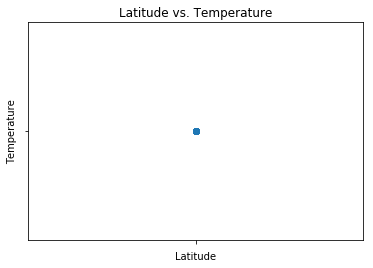

In [17]:
# Temperature vs. Latitude
plt.scatter(cities_list["Latitude"],cities_list["Max Temperature"], alpha = 0.75)

plt.title("Latitude vs. Temperature")
plt.xlabel("Latitude")
plt.ylabel("Temperature")
plt.savefig("Temperature.png")
plt.show()

#### Latitude vs. Humidity Plot

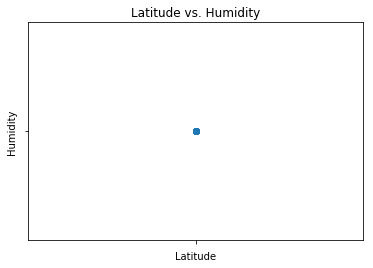

In [16]:
plt.scatter(cities_list["Latitude"],cities_list["Humidity"], alpha = 0.75)

plt.title("Latitude vs. Humidity")
plt.xlabel("Latitude")
plt.ylabel("Humidity")
plt.savefig("Humidity.png")
plt.show()

#### Latitude vs. Cloudiness Plot

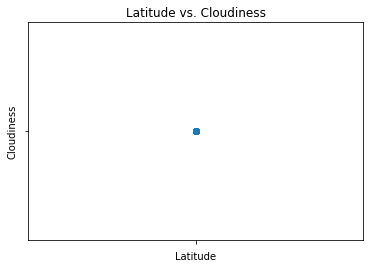

In [12]:
plt.scatter(cities_list["Latitude"],cities_list["Cloudiness"], alpha = 0.75)

plt.title("Latitude vs. Cloudiness")
plt.xlabel("Latitude")
plt.ylabel("Cloudiness")
plt.savefig("Cloudiness.png")
plt.show()

#### Latitude vs. Wind Speed Plot

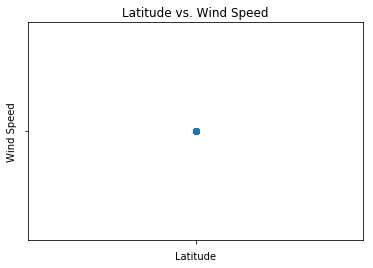

In [13]:
plt.scatter(cities_list["Latitude"],cities_list["Wind Speed"], alpha= 0.75)

plt.title("Latitude vs. Wind Speed")
plt.xlabel("Latitude")
plt.ylabel("Wind Speed")
plt.savefig("Wind Speed.png")
plt.show()